<a href="https://colab.research.google.com/github/SilverViking/fourier-manim/blob/main/fourier_manim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Analysis of 2D Curves

Frank Vernaillen, February 2022

## Introduction

In this notebook we will explore Fourier analysis of closed curves in the 2D plane. Our inspiration is the elegant-as-always [exposition](https://www.youtube.com/watch?v=r6sGWTCMz2k&t=121s) by 3blue1brown. 

The 2D curve will be represented by a parametric function in the complex plane.

### Fourier series decomposition

A closed parametric curve $f(t)$ in the complex plane can be decomposed as
$$f(t) = \sum_{n=-\infty}^{n=+\infty}{c_n e^{n \cdot 2\pi i t}} $$
with complex coeffcients $c_n$ given by
$$c_n=\int_0^1{f(t)e^{-n \cdot 2\pi i t} dt}$$

So $f(t)$ can be viewed as a (possibly infinite) sum of rotating vectors $e^{n \cdot 2\pi i t}$. Each vector rotates at a different but uniform angular velocity determined by $n$. Each vector is also scaled by the complex coefficient $c_n$, which means that its length is scaled by $|c_n|$, and that its starting angle is given by $\arg(c_n)$.

## Manim animation

We will now write a [manim](https://docs.manim.community/en/stable/index.html) animation to demonstrate this decomposition on an arbitratry 2D closed curve.

We first need to install anim and its support libraries. Execute the cell below and wait for the message asking to restart the kernel to appear. Click the `RESTART RUNTIME` button and then execute the cell again to complete the installation.

In [1]:
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim
!pip install IPython --upgrade

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad

In [2]:
!pip install svgpathtools

First we import the manim library, as well as some convenient support libraries.

In [3]:
from manim import *

Manim Community v0.14.0

In [4]:
import math
import cmath
import numpy as np
from typing import Callable, Dict, List, Tuple
from matplotlib import pyplot as plt 

Our 2D curves will be represented as a parametric function that takes a real value as input and returns a point in the complex plane. Let's define it as the type `ComplexFunc`.

In [5]:
ComplexFunc = Callable[[float], complex]

To determine the Fourier coefficients we need to evaluate the definite integral defined above. We will do so using a simple numeric integration procedure.

In [6]:
def integrate(f: ComplexFunc, lo: float, hi: float, num_steps=100) -> complex:
  # Calculate the definite integral of the function f over the interval [lo, hi].
  # The integral is approximated as its Riemann sum with `num_steps` samples over the interval.
  assert lo <= hi
  dt = (hi - lo) / num_steps
  integral = 0
  for i in range(num_steps):
    t = lo + i * dt
    integral += f(t) * dt
  return integral  

assert abs(integrate(lambda t: t, 0, 1) - 0.5) < 0.1
assert abs(integrate(lambda t: 2 * t, 0, 2) - 4) < 0.1
assert abs(integrate(lambda t: t, -1, 1)) < 0.1

We can now calculate the Fourier coefficients for any complex parametric function `f`.

In [7]:
def fourier_coefficient(n: int, f: ComplexFunc) -> complex:
  # Returns the n-th Fourier series coefficient for the function f
  def integrand(t):
    return f(t) * cmath.exp(complex(0, -n * 2 * np.pi * t))
  return integrate(integrand, 0, 1)

The `fourier_analysis` function calculates a desired number of Fourier coeffcients for a given parametric function `f`.

In [8]:
FourierSeries = Dict[int, complex]

def fourier_series(f: ComplexFunc, num_coeffs: int=11) -> FourierSeries:
  # Returns a dictionary with (the lowest frequency components of) the Fourier series for f.
  # The (key, value) entries in the dictionary are (n, n-th Fourier coefficient of f),
  # where n = ..., -3, -2, -1, 0, 1, 2, 3, ...
  fourier = {}
  for i in range(num_coeffs):
    n = i - num_coeffs // 2
    fourier[n] = fourier_coefficient(n, f)
  return fourier

For testing and for playing around with Fourier analysis we also define a couple of simple curves.

In [9]:
def complex_unit_circle(t: float) -> complex:    # as t varies from 0 to 1 we trace the unit circle
  return cmath.exp(complex(0, 2 * np.pi * t))

In [10]:
def complex_ellipse(t: float) -> complex:
  t = 2 * np.pi * t
  angle = np.pi / 12   # a 15° rotation angle for the big axis of the ellipse
  a, b = 2, 1
  return cmath.exp(complex(0, angle)) * complex(a * math.cos(t), b * math.sin(t))

In [11]:
def clerp(a: complex, b: complex, t: complex) -> complex:   # t in 0..1
  # complex linear interpolation
  return a + (b - a) * t

def complex_polygon(n: int, t: float) -> complex:
  # regular n-gon inscribed in the unit circle
  assert n > 2
  corners = [cmath.exp(complex(0, 2 * np.pi * i / n)) 
             for i in range(n)]
  t = t % 1
  assert (t >= 0) and (t < 1)

  # Figure out which polygon edge i to interpolate along,
  # using what interpolation factor t.
  i = int(t * n)
  t = n * (t - i / n)
  return clerp(corners[i], corners[(i + 1) % n], t)

from functools import partial
complex_triangle = partial(complex_polygon, 3)
complex_square = partial(complex_polygon, 4)
complex_hexagon = partial(complex_polygon, 6)

In [12]:
def complex_heart(t: float) -> complex:  
  # Heart shaped parametric curve in the complex plane 
  # see https://mathworld.wolfram.com/images/eps-gif/HeartCurves_801.gif
  t = 2 * np.pi * t
  x = 16 * math.pow(math.sin(t), 3)
  y = (13 * math.cos(t) - 5 * math.cos(2*t) - 2 * math.cos(3*t) - math.cos(4*t))
  return complex(x, y)

In [13]:
def complex_hypocycloid(t: float) -> complex:
  # See https://math.libretexts.org/Bookshelves/Calculus/Map%3A_Calculus__Early_Transcendentals_(Stewart)/10%3A_Parametric_Equations_And_Polar_Coordinates/10.01%3A_Curves_Defined_by_Parametric_Equations
  a = 4
  b = 1
  t = 2 * np.pi * b  * t  
  x = (a - b) * math.cos(t) + b * math.cos(t * (a - b) / b)
  y = (a - b) * math.sin(t) - b * math.sin(t * (a - b) / b)
  return complex(x, y)

In [14]:
def complex_hypotrochoid(t: float) -> complex:
  # A hypotrochoid is a curve traced by a point attached to a circle of radius r 
  # rolling around the inside of a fixed circle of radius R, where the point is 
  # at a distance d from the center of the interior circle.
  # See https://en.wikipedia.org/wiki/Parametric_equation#Hypotrochoid
  # R, r, d = 3, 1, 1
  R, r, d = 5, 3, 5
  t = 2 * np.pi * r * t  
  x = (R - r) * math.cos(t) + d * math.cos(t * (R - r) / r)
  y = (R - r) * math.sin(t) - d * math.sin(t * (R - r) / r)
  return complex(x, y)

In [15]:
def complex_lissajous(t: float) -> complex:   # t=0..1
  t = 2 * np.pi * t
  x = math.cos(3 * t)
  y = math.sin(2 * t)
  return complex(x, y)

Let's also support SVG files as curve definitions. The SVG is assumed to contain a single closed path describing the 2D curve.

In [16]:
import svgpathtools
from svgpathtools import svg2paths, Path

def complex_svg(filename: str) -> ComplexFunc:
  paths, _ = svg2paths(filename)
  assert len(paths) == 1
  path = paths[0]
  def complex_svg_curve(t: float) -> complex:    # the svgpathtools libraries guarantees that t in [0,1] exactly traces out the path
    return path.point(t).conjugate()             # conjugate to flip the y-axis
  return complex_svg_curve

For debugging purposes we also write a couple of functions to truncate small non-zero Fourier coefficients to zero.

In [17]:
def complex_truncate(c: complex, eps: float=1e-6) -> complex:
  # Truncate the real and the imaginary parts of the complex number to
  # zero if their absolute value is small.
  re, im = c.real, c.imag
  if abs(re) < eps:
    re = 0
  if abs(im) < eps:
    im = 0
  return complex(re, im)

In [18]:
def simplified_fourier_series(fourier: FourierSeries, min_magnitude: float=1e-6) -> FourierSeries:
  # Given a dictionary with Fourier coefficients, simplify it by
  # discarding small Fourier coefficients. This is mostly a debugging function,
  # to make it easier to spot patterns in the Fourier series expansion
  # of some functions where the Fourier coefficients should be zero
  # but instead are small non-zero due to numeric inaccuracies.
  simplified = {}
  for n, c in fourier.items():
    c = complex_truncate(c)
    if abs(c) > min_magnitude:
      simplified[n] = c
  return simplified

Let's calculate the Fourier coefficients for some example curves, to see if they make sense.

In [19]:
print(simplified_fourier_series(fourier_series(complex_unit_circle, num_coeffs=19)))
print(simplified_fourier_series(fourier_series(complex_ellipse, num_coeffs=19)))
print(fourier_series(complex_ellipse, num_coeffs=2))
print(simplified_fourier_series(fourier_series(complex_triangle, num_coeffs=27)))
print(simplified_fourier_series(fourier_series(complex_square, num_coeffs=27)))
print(simplified_fourier_series(fourier_series(complex_heart, num_coeffs=31)))
print(fourier_series(complex_lissajous, num_coeffs=13))
print(simplified_fourier_series(fourier_series(complex_hypotrochoid, num_coeffs=13)))
print(simplified_fourier_series(fourier_series(complex_hypocycloid, num_coeffs=13)))
print(simplified_fourier_series(fourier_series(complex_svg('circle.svg'), num_coeffs=13)))

{1: (1.0000000000000007+0j)}
{-1: (0.4829629131445343+0.12940952255126034j), 1: (1.4488887394336023+0.38822856765378105j)}
{-1: (0.4829629131445343+0.12940952255126034j), 0: (-1.0408340855860843e-16-1.5525775109992423e-16j)}
{-13: (8.749045801801063e-05+0j), -12: (0.00011821077861872645+0j), -11: (0.005677281275637243+0j), -10: (8.986714366649058e-05+0j), -9: (0.0001128781434676495+0j), -8: (0.010711253718336254+0j), -7: (9.2527036599864e-05+0j), -6: (0.00010810689369172843+0j), -5: (0.02738173329718256+0j), -4: (9.549799727086826e-05+0j), -3: (0.00010383244307024184+0j), -2: (0.17100449958984318+0j), -1: (9.881247110493652e-05+0j), 0: (9.999999999998552e-05+0j), 1: (0.6839429901341011+0j), 2: (0.00010250830754672882+0j), 3: (9.656290461544821e-05+0j), 4: (0.04276988312453691+0j), 5: (0.00010662976665767182+0j), 6: (9.348129299750763e-05+0j), 7: (0.013982536881735834+0j), 8: (0.00011122876252547993+0j), 9: (9.07210177723463e-05+0j), 10: (0.0068642348225828095+0j), 11: (0.00011636640799

We can also plot the Fourier spectrum as a more human understandable way to represent the Fourier coefficients.

In [20]:
from matplotlib.ticker import MaxNLocator

def plot_spectrum(fourier: FourierSeries) -> None:
  ns, coeffs = fourier.keys(), fourier.values()
  magnitudes = [abs(coeff) for coeff in coeffs]
  phases = [cmath.phase(coeff) for coeff in coeffs]

  # IMPROVEME: add plot title (parameter)
  # IMPROVEME: show phase y-axis as pi/2 multiples
  # IMPROVEME: add magnitude and phase labels to the plot

  f, ax = plt.subplots(2, sharex=True)
  ax[0].set_title('Fourier spectrum')
  ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
  ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
  ax[0].bar(ns, magnitudes)
  ax[1].bar(ns, phases)

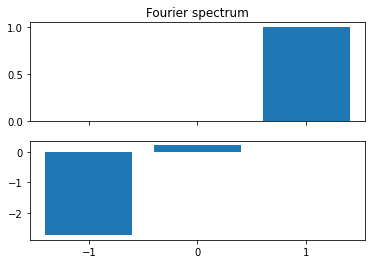

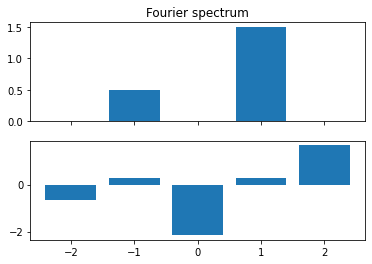

In [21]:
plot_spectrum(fourier_series(complex_unit_circle, num_coeffs=3))
plot_spectrum(fourier_series(complex_ellipse, num_coeffs=5))

We can now write a manim animation that first does a Fourier decomposition of any given closed curve in the 2D plane, and then animates the sum of the rotating vectors from the (truncated) Fourier decomposition, tracing out (an arbitrarily accurate approximation of) the original curve.

{-9: (0.04235561408115645+0.040235344413219604j), -8: (0.0513506395474031+0.06585609185327128j), -7: (0.018886230381473343-0.1736898109922281j), -6: (-0.23826166078608835+0.2296791281959087j), -5: (-0.24353708969572796+0.027875330409778857j), -4: (-0.026724547242397294-0.11817232388065305j), -3: (0.12526885184932834+0.4690883396338931j), -2: (-0.45692525813043594+0.06968635956355637j), -1: (-1.5667731612388414-0.4324331699737846j), 0: (0.00038305169422055835+0.06261554132624275j), 1: (-0.1324035286539984+0.15445945296666774j), 2: (-0.1927756173491706-0.268795002584418j), 3: (0.062191237125829815+0.04323242248706679j), 4: (0.019517587863665215-0.1312288194038626j), 5: (0.010660423150922107+0.20107667059194018j), 6: (0.19766445633807742+0.0032295346065010604j), 7: (0.09132530035617228+0.0631628178805674j), 8: (0.026194649912244527-0.10928833435765585j), 9: (-0.037516584068405495+0.08336728050217326j)}
{-9: (0.04235561408115645+0.040235344413219604j), -8: (0.0513506395474031+0.06585609185

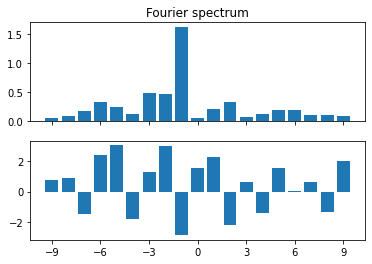

In [24]:
%%manim -qh -v WARNING FourierCurve

from dataclasses import dataclass

ANIMATION_SPEED = 0.4  # for adjusting the animation speed of the movie that manim produces

@dataclass
class RotatingArrow:  # rotating arrow corresponding to a term in the Fourier series of a 2D curve
  arrow: Line         # manim object representing a rotating arrow
  rate: float         # arrow rotation rate
  length: float       # arrow length

class FourierCurve(Scene):

  def create_rotating_arrow(self, n: int, coef: complex) -> RotatingArrow:
    length = abs(coef)   # length of the rotating vector
    angle = cmath.phase(coef)

    startpt = np.array([0, 0, 0])

    x = length * math.cos(angle)
    y = length * math.sin(angle)
    endpt = np.array([x, y, 0])

    ra = RotatingArrow(Line(startpt, endpt, buff=0, color=WHITE, stroke_opacity=0.5),
                       #Arrow(startpt, endpt, buff=0, color=WHITE, stroke_opacity=0.5, stroke_width=3, max_stroke_width_to_length_ratio=1, tip_style={'fill_opacity': 0.5}),
                       n,
                       length)
    return ra

  def attach_rotating_arrow(self, arrow: RotatingArrow, prev_arrow: RotatingArrow) -> None:
    # Attach arrow to the end of prev_arrow.
    if prev_arrow is None:
      return
    p = prev_arrow.arrow.get_end()
    delta = p - arrow.arrow.get_start()
    arrow.arrow.put_start_and_end_on(arrow.arrow.get_start() + delta,
                                     arrow.arrow.get_end() + delta)

  def make_objs(self, fourier: FourierSeries)-> Tuple[List[Line], List[Circle], Dot, VGroup]:
    def get_delta(prev_ra: RotatingArrow, ra: RotatingArrow):
      if prev_ra is None:
        return np.array([0,0,0])
      else:
        return prev_ra.arrow.get_end() - ra.arrow.get_start()      

    def update_arrow(prev_ra: RotatingArrow, ra: RotatingArrow, mob, dt) -> None:
      # Rotate arrow 'ra' for a small time step dt,
      # and position it at the end of the previous arrow 'prev_ra'.
      mob.rotate(2 * np.pi * ra.rate * dt * ANIMATION_SPEED,
                 about_point=mob.get_start())
      delta = get_delta(prev_ra, ra)
      mob.put_start_and_end_on(mob.get_start() + delta, mob.get_end() + delta)

    def make_dot(arrows: List[RotatingArrow]) -> Dot:
      # Make a dot positioned at the end of the last rotating arrow.
      dot = Dot(radius=0.05, color=RED)
      pos = arrows[-1].arrow.get_end()
      dot.move_to(pos)
      return dot

    def make_circle(ra: RotatingArrow) -> Circle:
      # Make a circle showing the path the rotating arrow will trace.
      circle = Circle(radius=ra.length, color=WHITE, stroke_opacity=0.5)
      circle.move_to(ra.arrow.get_start())
      return circle

    def make_curve(dot: Dot, curve=VGroup()) -> VGroup:
      # Make a curve that gets continuously extended with the position of the dot.
      if len(curve) == 0:
        prev_pos = dot.get_center()
      else:
        prev_pos = curve[-1].get_end()
      curve.add(Line(prev_pos, dot.get_center(), color=RED))
      return curve
  
    # Construct a rotating arrow for each of the components in the Fourier series
    arrows = []
    prev_arrow = None
    for n, coef in fourier.items():
      # Create an arrow, initially positioned at the origin
      arrow = self.create_rotating_arrow(n, coef)

      # Attach the new arrow at the end of the previous arrow
      self.attach_rotating_arrow(arrow, prev_arrow)

      # Add an updater to the arrow so it gets updated in small timesteps
      # during the animation.
      arrow.arrow.add_updater(partial(update_arrow, prev_arrow, arrow))

      arrows.append(arrow)
      prev_arrow = arrow

    # Now collect all the geometry we need to add to the scene:
    # the arrows, the circles, the moving dot and the curve traced by the dot.
    circles = [always_redraw(partial(make_circle, ra)) for ra in arrows]
    dot = always_redraw(partial(make_dot, arrows))
    curve = always_redraw(partial(make_curve, dot))
    return [ra.arrow for ra in arrows], circles, dot, curve
      
  def construct(self):
    # fourier = fourier_series(lambda t: 4 * complex_triangle(t), 5)
    # fourier = fourier_series(lambda t: 2 * complex_square(t), 7) 
    # fourier = fourier_series(lambda t: 3 * complex_hexagon(t), 11) 
    # fourier = fourier_series(lambda t: 0.2 * complex_heart(t), 17)
    # fourier = fourier_series(lambda t: 2 * complex_ellipse(t), 9)
    # fourier = fourier_series(lambda t: 0.75 * complex_hypocycloid(t), 7)
    # fourier = fourier_series(lambda t: 2 * complex_lissajous(t), 5)
    # fourier = fourier_series(lambda t: 0.5 * complex_hypotrochoid(t), 15)
    fourier = fourier_series(lambda t: 0.04 * complex_svg('scribble.svg')(t), 19)

    # Discard tiny Fourier coefficients as they result in tiny (zero length)
    # arrows being drawn which result in a manim error.
    print(fourier)
    fourier = {n: coeff for n, coeff in fourier.items() if abs(coeff) > 1e-6}
    plot_spectrum(fourier)
    print(fourier)

    # Construct rotating circles and vectors
    arrows, circles, dot, curve = self.make_objs(fourier)

    # Add everything to the scene
    # Note: the order in which we add the objects to the scene is important:
    # the arrows must be added first so they get drawn first too, because the circles 
    # will center themselves on the updated arrow endpoints.
    self.add(NumberPlane())  # for debugging / object size context
    self.add(*arrows, *circles, dot, curve)
    self.wait(2.5) 

## Future work
- Use arrows instead of line segments, but make them more uniform in appearance (tip size, thickness) than Arrow
- Make a grid with different curves versus different number of Fourier coefficients, all animating at the same time.
- Experiment with automatically building 1 single closed 2D curve that approximates a given grayscale image (e.g. a portrait of a person). Perhaps by first applying an edge detector and then calculating a kind of constrained Hamiltonian path through the image, trying to maximize the number of edge pixels passed under the constraint of a given path length (or so)... This would likely demand a heuristic solution.
- Instead of manually calculating the Fourier coefficients, we could use the FFT transform. Perhaps demonstrate this.
- Plot magnitude and phase of the Fourier coefficients